In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNetCV
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) # get rid of depreciation warnings

In [125]:
data = pd.read_csv("/Users/jacobbills/Desktop/Economics/Twitter_sentiment_DJIA30/Combined_stocks.csv") 
#brings in the csv

Let's make some percents for the different sentiment scores

In [126]:
data.info() #checking what we have

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14182 entries, 0 to 14181
Data columns (total 56 columns):
Unnamed: 0    14182 non-null int64
Date          14182 non-null object
HIGH          14182 non-null float64
CLOSE         14182 non-null float64
OPEN          14182 non-null float64
LOW           14182 non-null float64
NUM_NEG       14182 non-null int64
NUM_NEU       14182 non-null int64
NUM_POS       14182 non-null int64
TW            14182 non-null int64
weekend       14182 non-null int64
NUM_NEG1      14182 non-null int64
NUM_NEG2      14182 non-null int64
NUM_NEG3      14182 non-null int64
NUM_NEU1      14182 non-null int64
NUM_NEU2      14182 non-null int64
NUM_NEU3      14182 non-null int64
NUM_POS1      14182 non-null int64
NUM_POS2      14182 non-null int64
NUM_POS3      14182 non-null int64
TW1           14182 non-null int64
TW2           14182 non-null int64
TW3           14182 non-null int64
CLOSE1        14182 non-null float64
CLOSE2        14182 non-null float64
CLO

In [127]:
# create industry type variables
def industrifier(df,list_):
    for i in range(len(df)):
        for e in list_:
            for x in e:
                if df.loc[i,x] == 1:
                    df.loc[i,str(e)] = 1
                else:
                    pass
    for e in list_:
        df.drop(columns=e, inplace=True)
    df.fillna(0)
    return df

In [79]:
# create percentages
sentiments = ['NUM_NEG', 'NUM_NEG1', 'NUM_NEG2', 'NUM_NEG3','NUM_NEU','NUM_NEU1','NUM_NEU2','NUM_NEU3','NUM_POS',
              'NUM_POS1','NUM_POS2', 'NUM_POS3']
for e in sentiments:
    if e.endswith("1"):
        data[e+"_PER"] = data[e]/data['TW1']
    elif e.endswith("2"):
        data[e+"_PER"] = data[e]/data['TW2']
    elif e.endswith("3"):
        data[e+"_PER"] = data[e]/data['TW3']
    else:
        data[e+"_PER"] = data[e]/data['TW']

In [80]:
# Create Dummies for each day
data['Date']= pd.to_datetime(data['Date'])
data['day'] = data['Date'].dt.day_name()

In [81]:
data =pd.get_dummies(data, columns=['day'])
data.head()

,Unnamed: 0,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,...,NUM_POS1_PER,NUM_POS2_PER,NUM_POS3_PER,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0,2013-06-04,77.24,76.02,76.50,75.96,2,12,6,20,...,0.090909,0.000000,0.000000,0,0,0,0,0,1,0
1,1,2013-06-05,76.28,74.79,76.04,74.64,0,4,2,6,...,0.300000,0.090909,0.000000,0,0,0,0,0,0,1
2,2,2013-06-06,76.25,76.24,74.75,74.64,1,9,0,10,...,0.333333,0.300000,0.090909,0,0,0,0,1,0,0
3,3,2013-06-07,78.12,78.03,76.68,76.45,2,4,11,17,...,0.000000,0.333333,0.300000,1,0,0,0,0,0,0
4,4,2013-06-08,78.12,78.03,76.68,76.45,0,3,3,6,...,0.647059,0.000000,0.333333,0,0,1,0,0,0,0


In [82]:
is_null = data.columns[data.isnull().any()] # seeing where there might be a problem
is_null

Index(['NUM_NEG_PER', 'NUM_NEG1_PER', 'NUM_NEG2_PER', 'NUM_NEG3_PER',
       'NUM_NEU_PER', 'NUM_NEU1_PER', 'NUM_NEU2_PER', 'NUM_NEU3_PER',
       'NUM_POS_PER', 'NUM_POS1_PER', 'NUM_POS2_PER', 'NUM_POS3_PER'],
      dtype='object')

In [83]:
data[is_null].info() # about 30 missing for each, for whatever reason

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14654 entries, 0 to 14653
Data columns (total 12 columns):
NUM_NEG_PER     14620 non-null float64
NUM_NEG1_PER    14620 non-null float64
NUM_NEG2_PER    14619 non-null float64
NUM_NEG3_PER    14619 non-null float64
NUM_NEU_PER     14620 non-null float64
NUM_NEU1_PER    14620 non-null float64
NUM_NEU2_PER    14619 non-null float64
NUM_NEU3_PER    14619 non-null float64
NUM_POS_PER     14620 non-null float64
NUM_POS1_PER    14620 non-null float64
NUM_POS2_PER    14619 non-null float64
NUM_POS3_PER    14619 non-null float64
dtypes: float64(12)
memory usage: 1.3 MB


In [84]:
for e in is_null: #just fill them in with whatever is closest
    data[e].fillna(data[e].mean(), inplace=True)

In [85]:
for i in range(len(data)): # create the classes
    if data.loc[i,"CLOSE"] > data.loc[i,"OPEN"]+.25:
        data.loc[i,"class"] = 1 # gained by more than $.25
    elif data.loc[i,"CLOSE"] < data.loc[i,'OPEN']-.25:
        data.loc[i,"class"] = 2 # lost by more than $.25 
    else:
        data.loc[i,"class"] = 0 # minimal change

In [86]:
data[["CLOSE", "OPEN", "Date", "weekend","class"]] #see how the data looks

,CLOSE,OPEN,Date,weekend,class
0,76.02,76.50,2013-06-04,0,2.0
1,74.79,76.04,2013-06-05,0,2.0
2,76.24,74.75,2013-06-06,0,1.0
3,78.03,76.68,2013-06-07,0,1.0
4,78.03,76.68,2013-06-08,1,1.0
5,78.03,76.68,2013-06-09,1,1.0
6,78.27,77.98,2013-06-10,0,1.0
7,76.52,77.61,2013-06-11,0,2.0
8,74.72,76.91,2013-06-12,0,2.0
9,75.21,74.46,2013-06-13,0,1.0


In [87]:
data = data.loc[data.weekend==0]
data.head() #drop out the weekend data since it doesn't really tell us anything and see if it worked (it did)

,Unnamed: 0,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,...,NUM_POS2_PER,NUM_POS3_PER,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,class
0,0,2013-06-04,77.24,76.02,76.50,75.96,2,12,6,20,...,0.000000,0.000000,0,0,0,0,0,1,0,2.0
1,1,2013-06-05,76.28,74.79,76.04,74.64,0,4,2,6,...,0.090909,0.000000,0,0,0,0,0,0,1,2.0
2,2,2013-06-06,76.25,76.24,74.75,74.64,1,9,0,10,...,0.300000,0.090909,0,0,0,0,1,0,0,1.0
3,3,2013-06-07,78.12,78.03,76.68,76.45,2,4,11,17,...,0.333333,0.300000,1,0,0,0,0,0,0,1.0
6,6,2013-06-10,78.61,78.27,77.98,77.69,0,6,7,13,...,0.500000,0.647059,0,1,0,0,0,0,0,1.0


In [88]:
target = data.CLOSE # target
target_class = data["class"] # target for classifiers
high = data.HIGH # other columns that we don't really need for now
low = data.LOW 

In [89]:
data1 = data.drop(columns=['CLOSE', 'HIGH', 'LOW', 'Unnamed: 0', 'class', 'day_Saturday', 'day_Sunday']) # get rid of those ones

In [90]:
data_nodate = data1.drop(columns='Date') # create a df without the dates

In [91]:
data_prev = data_nodate.drop(columns=['NUM_NEG', 'NUM_NEU', 'NUM_POS', 'NUM_NEG_PER', 'NUM_NEU_PER', 'NUM_POS_PER', "TW"])
# create a df without anything for the day of interest

In [92]:
data_nopen_date = data_nodate.drop(columns='OPEN')
data_nopen_prev = data_prev.drop(columns='OPEN')

In [93]:
# turn everything into floats so that scaler is happy

data_nodate = pd.DataFrame(data_nodate, dtype='float')
data_prev = pd.DataFrame(data_prev, dtype='float')
data_nopen_date = pd.DataFrame(data_nopen_date, dtype='float')
data_nopen_prev = pd.DataFrame(data_nopen_prev, dtype='float')

In [94]:
data_nopen_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10159 entries, 0 to 14653
Data columns (total 60 columns):
weekend          10159 non-null float64
NUM_NEG1         10159 non-null float64
NUM_NEG2         10159 non-null float64
NUM_NEG3         10159 non-null float64
NUM_NEU1         10159 non-null float64
NUM_NEU2         10159 non-null float64
NUM_NEU3         10159 non-null float64
NUM_POS1         10159 non-null float64
NUM_POS2         10159 non-null float64
NUM_POS3         10159 non-null float64
TW1              10159 non-null float64
TW2              10159 non-null float64
TW3              10159 non-null float64
CLOSE1           10159 non-null float64
CLOSE2           10159 non-null float64
CLOSE3           10159 non-null float64
AXP              10159 non-null float64
BA               10159 non-null float64
CAT              10159 non-null float64
CSCO             10159 non-null float64
CVX              10159 non-null float64
DD               10159 non-null float64
DIS        

Now that the data is clean, we can try to run some different models on it

In [95]:
scaler = StandardScaler() #scale each of the three sets with open

scaler.fit(data_nodate)
scaled_df_noo = scaler.transform(data_nodate)

scaler.fit(data_prev)
scaled_prevo = scaler.transform(data_prev)

In [96]:
# break into test and training sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(scaled_df_noo, target, test_size=.2, random_state = 11)
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_prevo, target, test_size=.2, random_state = 11)

In [97]:
#plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=5)

In [98]:
# elastic net without dates
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train1, y_train1)
train_predictions = clf.predict(X_train1)
test_predictions = clf.predict(X_test1)
print("Train MSE: {}".format(mean_squared_error(y_train1, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test1, test_predictions)))

Train MSE: 0.6948907948158737
Test MSE: 0.6032102402205742


In [99]:
# same as above
sorted(list(zip(data_nodate, clf.coef_)), key=lambda x: abs(x[1]))

[('NUM_NEG', -0.0),
 ('NUM_NEU', -0.0),
 ('NUM_POS', 0.0),
 ('TW', -0.0),
 ('weekend', 0.0),
 ('NUM_NEG1', -0.0),
 ('NUM_NEG2', 0.0),
 ('NUM_NEG3', 0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_NEU3', -0.0),
 ('NUM_POS1', -0.0),
 ('NUM_POS2', 0.0),
 ('NUM_POS3', 0.0),
 ('TW1', -0.0),
 ('TW2', 0.0),
 ('TW3', 0.0),
 ('CLOSE2', 0.0),
 ('CLOSE3', 0.0),
 ('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('PFE', -0.0),
 ('PG', -0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('UNH', 0.0),
 ('UTX', 0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', 0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', -0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEG3_PER', 0.0),
 ('NUM_NEU_PER', -0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_NEU3_PER', -0.0),
 ('NUM_POS1_

In [100]:
# elastic net without today's data
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train2, y_train2)
train_predictions = clf.predict(X_train2)
test_predictions = clf.predict(X_test2)
print("Train MSE: {}".format(mean_squared_error(y_train2, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test2, test_predictions)))

Train MSE: 0.7003492633051123
Test MSE: 0.6075214545452414


In [101]:
sorted(list(zip(data_prev, clf.coef_)), key=lambda x: abs(x[1]))

[('weekend', 0.0),
 ('NUM_NEG1', -0.0),
 ('NUM_NEG2', 0.0),
 ('NUM_NEG3', 0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_NEU3', -0.0),
 ('NUM_POS1', -0.0),
 ('NUM_POS2', 0.0),
 ('NUM_POS3', 0.0),
 ('TW1', -0.0),
 ('TW2', 0.0),
 ('TW3', 0.0),
 ('CLOSE2', 0.0),
 ('CLOSE3', 0.0),
 ('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('PFE', -0.0),
 ('PG', -0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('UNH', 0.0),
 ('UTX', 0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', 0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', -0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEG3_PER', 0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_NEU3_PER', -0.0),
 ('NUM_POS1_PER', -0.0),
 ('NUM_POS2_PER', 0.0),
 ('NUM_POS3_PER', 0.0),
 ('day_Friday', 0.0),
 ('day_Monday',

In [102]:
# scale the data wihtout open
scaler.fit(data_nopen_date)
scaled_df_non = scaler.transform(data_nopen_date)

scaler.fit(data_nopen_prev)
scaled_prevn = scaler.transform(data_nopen_prev)

In [103]:
# create training sets
X_train4, X_test4, y_train4, y_test4 = train_test_split(scaled_df_non, target, test_size=.2, random_state = 11)
X_train5, X_test5, y_train5, y_test5 = train_test_split(scaled_prevn, target, test_size=.2, random_state = 11)

In [104]:
# Elastic net with no dates
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train4, y_train4)
train_predictions = clf.predict(X_train4)
test_predictions = clf.predict(X_test4)
print("Train MSE: {}".format(mean_squared_error(y_train4, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test4, test_predictions)))
print(sorted(list(zip(data_nopen_date, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 0.9595450259558125
Test MSE: 0.7892453635364851
[('NUM_NEG', -0.0), ('NUM_NEU', -0.0), ('NUM_POS', 0.0), ('TW', -0.0), ('weekend', 0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', 0.0), ('NUM_NEG3', 0.0), ('NUM_NEU1', -0.0), ('NUM_NEU2', -0.0), ('NUM_NEU3', -0.0), ('NUM_POS1', -0.0), ('NUM_POS2', -0.0), ('NUM_POS3', 0.0), ('TW1', -0.0), ('TW2', -0.0), ('TW3', -0.0), ('AXP', -0.0), ('BA', 0.0), ('CAT', 0.0), ('CSCO', -0.0), ('CVX', 0.0), ('DD', -0.0), ('DIS', -0.0), ('GE', -0.0), ('GS', 0.0), ('HD', -0.0), ('IBM', 0.0), ('INTC', -0.0), ('JNJ', 0.0), ('JPM', 0.0), ('KO', -0.0), ('MCD', 0.0), ('MMM', 0.0), ('MRK', -0.0), ('MSFT', -0.0), ('NKE', -0.0), ('PFE', -0.0), ('PG', -0.0), ('T', -0.0), ('TRV', 0.0), ('UNH', -0.0), ('UTX', 0.0), ('V', 0.0), ('VZ', -0.0), ('WMT', 0.0), ('XOM', 0.0), ('NUM_NEG1_PER', -0.0), ('NUM_NEG2_PER', 0.0), ('NUM_NEG3_PER', 0.0), ('NUM_NEU_PER', -0.0), ('NUM_NEU1_PER', 0.0), ('NUM_NEU2_PER', -0.0), ('NUM_NEU3_PER', -0.0), ('NUM_POS1_PER', -0.0), ('NUM_POS2_PER'

In [105]:
# elastic net without anything from the day being predicted
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train5, y_train5)
train_predictions = clf.predict(X_train5)
test_predictions = clf.predict(X_test5)
print("Train MSE: {}".format(mean_squared_error(y_train5, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test5, test_predictions)))
print(sorted(list(zip(data_nopen_prev, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 1.0074518409183346
Test MSE: 0.8312476433891135
[('weekend', 0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', -0.0), ('NUM_NEG3', 0.0), ('NUM_NEU1', -0.0), ('NUM_NEU2', -0.0), ('NUM_NEU3', -0.0), ('NUM_POS1', -0.0), ('NUM_POS2', -0.0), ('NUM_POS3', 0.0), ('TW1', -0.0), ('TW2', -0.0), ('TW3', -0.0), ('CLOSE2', 0.0), ('AXP', -0.0), ('BA', 0.0), ('CAT', 0.0), ('CSCO', -0.0), ('CVX', 0.0), ('DD', -0.0), ('DIS', 0.0), ('GE', -0.0), ('GS', 0.0), ('HD', -0.0), ('IBM', 0.0), ('INTC', -0.0), ('JNJ', 0.0), ('JPM', -0.0), ('KO', -0.0), ('MCD', -0.0), ('MMM', 0.0), ('MRK', -0.0), ('MSFT', -0.0), ('NKE', 0.0), ('PFE', -0.0), ('PG', -0.0), ('T', -0.0), ('TRV', 0.0), ('UNH', 0.0), ('UTX', 0.0), ('V', 0.0), ('VZ', -0.0), ('WMT', -0.0), ('XOM', 0.0), ('NUM_NEG1_PER', -0.0), ('NUM_NEG2_PER', 0.0), ('NUM_NEG3_PER', 0.0), ('NUM_NEU1_PER', 0.0), ('NUM_NEU2_PER', -0.0), ('NUM_NEU3_PER', -0.0), ('NUM_POS1_PER', 0.0), ('NUM_POS2_PER', 0.0), ('NUM_POS3_PER', 0.0), ('day_Friday', 0.0), ('day_Monday', 0.0), ('d

As can be seen, it isn't very interesting to use the data to predict future prices because it ends up that basically the only thing you want to know is what the opening price/yesterday's price is, and then how people were tweeting the day of (possibly after closing). So instead we'll try to predict if tweets can forecast if the stock is going to go up or down. The "previous" data is the most important sort here

In [66]:
from sklearn.neighbors import KNeighborsClassifier #Nearest Neighbors
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB # different Bayesian models
from sklearn.svm import SVC #support vector machine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier #ensemble models

from sklearn.model_selection import GridSearchCV #to do cross validation

# Metrics
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error #different ways of scoring
from sklearn.metrics import classification_report # classification report
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

In [106]:
# create training sets from the previous day data (with and without OPEN)
X_traincO, X_testcO, y_traincO, y_testcO = train_test_split(scaled_prevo, target_class, test_size=.2, random_state = 11)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(scaled_prevn, target_class, test_size=.2, random_state = 11)

In [103]:
# K Nearest Neighbors with open
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_traincO, y_traincO)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_traincO)
print("Train F1: {}".format(f1_score(y_traincO, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testcO)
print(classification_report(y_testcO, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_traincO, y_pred_train),
                                                     accuracy_score(y_testcO, y_pred_test)))

Best Params: {'n_neighbors': 11, 'p': 3, 'weights': 'distance'}
Train F1: [1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.65      0.59       810
         1.0       0.42      0.43      0.43       630
         2.0       0.39      0.29      0.33       592

   micro avg       0.47      0.47      0.47      2032
   macro avg       0.45      0.45      0.45      2032
weighted avg       0.46      0.47      0.46      2032

Train Accuracy: 1.0	Test accuracy: 0.4749015748031496


In [105]:
# confusion matric to evaluate performance
confusion_matrix(y_testcO, y_pred_test)

array([[525, 166, 119],
       [215, 271, 144],
       [222, 201, 169]])

In [106]:
# K Nearest Neighbors without open
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainc, y_trainc)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainc)
print("Train F1: {}".format(f1_score(y_trainc, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testc)
print(classification_report(y_testc, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainc, y_pred_train),
                                                     accuracy_score(y_testc, y_pred_test)))
print(confusion_matrix(y_testc, y_pred_test))

Best Params: {'n_neighbors': 11, 'p': 3, 'weights': 'distance'}
Train F1: [1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.65      0.59       810
         1.0       0.43      0.43      0.43       630
         2.0       0.39      0.29      0.33       592

   micro avg       0.48      0.48      0.48      2032
   macro avg       0.46      0.46      0.45      2032
weighted avg       0.46      0.48      0.47      2032

Train Accuracy: 1.0	Test accuracy: 0.4763779527559055
[[525 165 120]
 [212 272 146]
 [220 201 171]]


So first of all this model is way overfitting, so that needs to be fixed. Removing "OPEN" made it only marginally better (talking like 2 more true positives for each class) so that indicates that OPEN is not a driving force for this problem (unlike the basic prediction problem). Secondly, it seems to mostly put things in the first class (no major change) which works okay but not great. It is really bad at predicting a drop in prices, so I'm not sure what is going on there, except that it probaly trained itself to mostly put things in the first class. I'll try a random forest, since we can get feature importances from that which may give valuable information about what variables to keep and what ones to drop so that we stop overfitting the nearest neighbors. 

In [111]:
# RandomForestClassifier with Open
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_traincO, y_traincO)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_traincO)
print("Train F1: {}".format(f1_score(y_traincO, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testcO)
print(classification_report(y_testcO, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_traincO, y_pred_train),
                                                     accuracy_score(y_testcO, y_pred_test)))
print(confusion_matrix(y_testcO, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500, 'random_state': 9}
Train F1: [0.66584982 0.76710796 0.73928158]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58       810
         1.0       0.38      0.40      0.39       630
         2.0       0.33      0.39      0.36       592

   micro avg       0.45      0.45      0.45      2032
   macro avg       0.45      0.44      0.44      2032
weighted avg       0.47      0.45      0.46      2032

Train Accuracy: 0.7226528854435831	Test accuracy: 0.4498031496062992
[[426 171 213]
 [121 255 254]
 [114 245 233]]


In [107]:
rfcb = RandomForestClassifier(n_estimators = 500, max_features='sqrt', min_samples_leaf=3, max_depth
                             = 11, class_weight='balanced')
rfcb.fit(X_traincO, y_traincO)
feature_imp_rfc1 = sorted(list(zip(data_prev, rfcb.feature_importances_)), key=lambda x: x[1], reverse=True)

In [67]:
# RandomForestClassifier without Open
rfc = RandomForestClassifier()

gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainc, y_trainc)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainc)
print("Train F1: {}".format(f1_score(y_trainc, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testc)
print(classification_report(y_testc, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainc, y_pred_train),
                                                     accuracy_score(y_testc, y_pred_test)))
print(confusion_matrix(y_testc, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 200, 'random_state': 9}
Train F1: [0.7497006  0.82321598 0.80287156]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58       810
         1.0       0.38      0.39      0.38       630
         2.0       0.33      0.40      0.36       592

   micro avg       0.45      0.45      0.45      2032
   macro avg       0.45      0.44      0.44      2032
weighted avg       0.47      0.45      0.46      2032

Train Accuracy: 0.7903285345145811	Test accuracy: 0.4478346456692913
[[430 162 218]
 [126 246 258]
 [117 241 234]]


In [108]:
rfcb2 = RandomForestClassifier(class_weight= 'balanced', max_depth= 11, max_features= None, min_samples_leaf= 3, 
                               n_estimators= 200, random_state= 9)
rfcb2.fit(X_trainc, y_trainc)
feature_imp_rfc2 = sorted(list(zip(data_nopen_prev, rfcb2.feature_importances_)), key=lambda x: x[1], reverse=True)

I'll now use an old set of functions I wrote to get plot out the most important features and then decide how to engineer from there.

In [63]:
def key_extract(dic):
    y = pd.DataFrame.from_dict(dic, orient='index') #turns the dictionary into a data frame
    y = y.index # list of the names in the dataframe
    return y

def feature_extract(data_frame, feature_importances, sensitivity): # function to extract a list of features above a given sensitivty
    coef_dict = dict((zip(data_frame, feature_importances))) #creates a dictionary from the model's feature importance
    coef_list = {} # another dictionary
    for key in coef_dict: # runs through the zipped dictionary 
        x = coef_dict.get(key) # extracts value for the key
        if abs(x) > sensitivity:  # if the absolute value is bigger than the sensitivity
            coef_list[key] = x # adds a new entry to the other dictionary 
        else: # if the coefficient isn't big enough
            pass # move to the next key
    coef_list = key_extract(coef_list) # uses a previous function I wrote to make a list of the names of those coeff
    return coef_list # returns that list

def best_feature_dict(list_, features_imp): #creates a dictionary from a list of tuples using another list of names
    y = {}
    for e in list_:
        y[e] = dict(features_imp).get(e)
    return y

def best_feature_plot(list_, features_imp, ticks=90): #plots the features importances
    y = best_feature_dict(list_, features_imp)
    plt.bar(y.keys(),y.values())
    plt.title("Feature Importance")
    plt.xticks(rotation=ticks)
    plt.ylabel("Percent Used")
    plt.grid(True)
    
def features_full(data_frame, feature_importances, sensitivity): #combines these functions into one nice one
    x = feature_extract(data_frame, feature_importances, sensitivity)
    z = sorted(list(zip(data_frame, feature_importances)), key=lambda x: x[1], reverse=True)
    y = best_feature_plot(x, z)
    return x, y

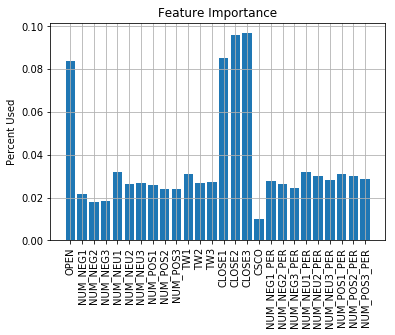

In [109]:
best_feat1, best_featplt1 = features_full(data_prev, rfcb.feature_importances_, .01)

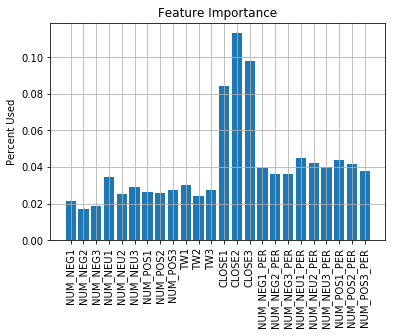

In [110]:
best_feat2, best_featplt2 = features_full(data_nopen_prev,rfcb2.feature_importances_, .01)

So the two models are quite similar and most importantly, sentiments does play a role in how these get classified. Next, we'll look at correlations between these higher importance features and then maybe mess with the data set a bit more to get a less overfitting k-nearest neighbors model (since that one is still working the best). Might try and SVM too, since lower amounts of features helps a lot with that. Also, once again, having OPEN doesn't really make a difference.

In [72]:
def corr_extract(var, sensitivity): # definine a function that will tell me where there is high correlation
    y = dict() #the plan is to get a dictionary that gives me the name and value
    count = 0 # set up the counter
    for e in var:
        if abs(e)<sensitivity: #most common is lower correlation so I'll get rid of those first
            count = count + 1 #move to the next one
        elif abs(e)==1: # get rid of perfect correlation because that isn't very interesting
            count = count + 1 #
        else: 
            x = var.index[count] #extract the name from the series
            y[x] = e #key: index, value: correlation
            count = count + 1 # move to the next one
    return y 

def i_corr_extract(list_corr, var, sensitivity): #for doing a correlation extract except iterated
    for x in list_corr:
        print(x)
        print(corr_extract(var[x], sensitivity))
        print()

In [111]:
feature_corr = data_nopen_prev[best_feat2].corr()
i_corr_extract(best_feat2, feature_corr, .3)

NUM_NEG1
{'NUM_NEG2': 0.40170196998031343, 'NUM_NEU1': 0.45451223511486377, 'NUM_POS1': 0.3093336961341877, 'TW1': 0.5852331398670126, 'NUM_NEG1_PER': 0.45800710807257766}

NUM_NEG2
{'NUM_NEG1': 0.40170196998031343, 'NUM_NEG3': 0.38798199354234814, 'NUM_NEU2': 0.46218589722712966, 'NUM_POS2': 0.3084674758077302, 'TW2': 0.5793150972614369, 'NUM_NEG2_PER': 0.4202407650999104}

NUM_NEG3
{'NUM_NEG2': 0.38798199354234814, 'NUM_NEU3': 0.47631873900540306, 'NUM_POS3': 0.304764618599842, 'TW3': 0.6027214587212899, 'NUM_NEG3_PER': 0.38717757134382996}

NUM_NEU1
{'NUM_NEG1': 0.45451223511486377, 'NUM_NEU2': 0.5337631597425944, 'NUM_NEU3': 0.3246033459685328, 'NUM_POS1': 0.5075420215691235, 'NUM_POS2': 0.3484913425862472, 'TW1': 0.9603049811683173, 'TW2': 0.5385755397393015, 'TW3': 0.3055004638263273}

NUM_NEU2
{'NUM_NEG2': 0.46218589722712966, 'NUM_NEU1': 0.5337631597425944, 'NUM_NEU3': 0.501403598019858, 'NUM_POS2': 0.4764761594909855, 'TW1': 0.5144154500339283, 'TW2': 0.9613166884037355, 'TW3'

Most of these correlations are quite obvious. Percentages are correlated with the number said that day and the number of any type of tweet on a given day is correlated with the other numbers. I might just drop all the numbers and reduce down to a pure percentage model, even though the correlation isn't super strong. The pure number of tweets on a given day is not correlated with the percentages though, so I think I'll leave those in as a sort of control. 

Unsurprisingly, the closing prices are very very very correlated with each other. I think I'll drop the numbers and then re-run the model to see how it goes.

In [116]:
sentiments_prev = []
for e in sentiments:
    if e.endswith('1'):
        sentiments_prev.append(e)
    elif e.endswith('2'):
        sentiments_prev.append(e)
    elif e.endswith('3'):
        sentiments_prev.append(e)
    else:
        pass

In [119]:
data_noprev_per = data_nopen_prev.drop(columns=sentiments_prev)

In [120]:
scaler.fit(data_noprev_per)
scaled_prevper = scaler.transform(data_noprev_per)

X_trainP, X_testP, y_trainP, y_testP = train_test_split(scaled_prevper, target_class, test_size=.2, random_state = 11)

In [122]:
# K Nearest Neighbors without open raw numbers dropped
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainP, y_trainP)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainP)
print("Train F1: {}".format(f1_score(y_trainP, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testP)
print(classification_report(y_testP, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainP, y_pred_train),
                                                     accuracy_score(y_testP, y_pred_test)))
print(confusion_matrix(y_testP, y_pred_test))

Best Params: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Train F1: [1. 1. 1.]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.65      0.61       810
         1.0       0.42      0.42      0.42       630
         2.0       0.39      0.31      0.35       592

   micro avg       0.48      0.48      0.48      2032
   macro avg       0.46      0.46      0.46      2032
weighted avg       0.47      0.48      0.47      2032

Train Accuracy: 1.0	Test accuracy: 0.4812992125984252
[[526 154 130]
 [207 267 156]
 [189 218 185]]


In [123]:
#Random Forest, raw numbers dropped
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainP, y_trainP)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainP)
print("Train F1: {}".format(f1_score(y_trainP, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testP)
print(classification_report(y_testP, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainP, y_pred_train),
                                                     accuracy_score(y_testP, y_pred_test)))
print(confusion_matrix(y_testP, y_pred_test))

KeyboardInterrupt: 

Another option for narrowing down the features list (and making this a bit less overfitting in the long run) is to use industries instead of dummies for each company. We used [this website](https://www.thestreet.com) to determine which companies were classified into which industries. Only two, United Health Group and du Pont had no comparable groups, so we just left those dummies as is.

In [ ]:
financial = ['AXP','GS','JPM','TRV']
electronic_tech = ['BA', 'CSCO', 'INTC']
producer_manu = ['CAT', 'GE', 'MMM','UTX']
minerals = ['CVX','XOM']
tech_services = ['IBM', 'MSFT','V']
basic_materials = ['DD']
consumer_services = ['DIS', 'MCD']
retail = ['HD','WMT']
health_tech = ['JNJ', 'MRK','PFE']
health_services = ['UNH']
non_durables = ['KO','NKE','PG']
comms = ['T','VZ']

industries = [financial, electronic_tech, producer_manu, minerals, consumer_services, tech_services, retail, 
              health_tech, non_durables, comms]

def industrifier(df,list_, drop=True):
    for i in range(len(df)):
        for e in list_:
            for x in e:
                if df.loc[i,x] == 1:
                    df.loc[i,str(e)] = 1
                else:
                    pass
    if drop==True:
        for e in list_:
            df.drop(columns=e, inplace=True)
        df.fillna(0,inplace=True)
    else:
        df.fillna(0,inplace=True)
    return df